In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
import pyproj
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline


bsas_map = gpd.read_file('../gopa_data/ba_comunas')


<AxesSubplot:>

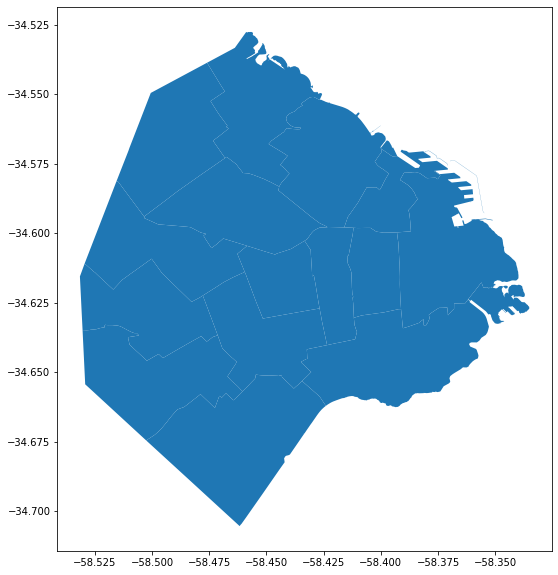

In [2]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax)


In [3]:
df = pd.read_csv('fourcorners.csv', ',')
epsg = 'epsg:22171'
df.head()

,dot,lat,lon
0,A,-34.534599,-58.531942
1,B,-34.534599,-58.334982
2,C,-34.705557,-58.334982
3,D,-34.705557,-58.531942


In [4]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geometry

In [5]:
geo_df = gpd.GeoDataFrame(df,
                         crs = epsg, 
                         geometry = geometry)
geo_df

,dot,lat,lon,geometry
0,A,-34.534599,-58.531942,POINT (-58.53194 -34.53460)
1,B,-34.534599,-58.334982,POINT (-58.33498 -34.53460)
2,C,-34.705557,-58.334982,POINT (-58.33498 -34.70556)
3,D,-34.705557,-58.531942,POINT (-58.53194 -34.70556)


<AxesSubplot:>

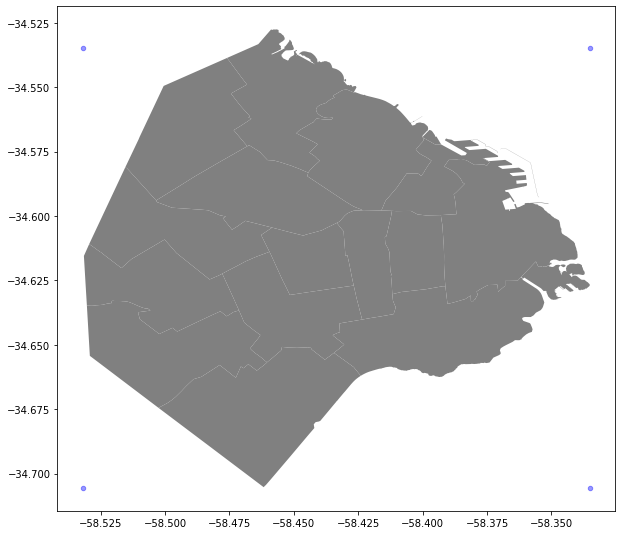

In [6]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax, color='grey')
geo_df.plot(ax=ax, markersize=20, alpha=0.4, color='blue')

In [7]:
# Set up projections
p_ll = pyproj.Proj('epsg:4326') # epsg mundo
p_mt = pyproj.Proj('EPSG:3857') # epsg argentinta


In [8]:
import shapely
sw = shapely.geometry.Point((-58.538143, -34.705557))
ne = shapely.geometry.Point((-58.350345, -34.532787))

stepsize = 500 # 500 m grid step size

In [9]:
# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to 22177
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

In [10]:
# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

In [11]:
import csv

with open('testoutbsas.csv', 'w') as of:
    of.write('lat,lon\n')
    for p in gridpoints:
        of.write('{:f},{:f}\n'.format(p.x, p.y))

In [12]:
df_coords = pd.read_csv('testoutbsas.csv', ',')
epsg = 'epsg:3857'
df_coords

,lat,lon
0,-58.538143,-34.705557
1,-58.535799,-34.705557
2,-58.533454,-34.705557
3,-58.531109,-34.705557
4,-58.528765,-34.705557
...,...,...
3115,-58.361880,-34.534877
3116,-58.359524,-34.534877
3117,-58.357167,-34.534877
3118,-58.354811,-34.534877


In [13]:
gdf = gpd.GeoDataFrame(
    df_coords, geometry=gpd.points_from_xy(df_coords.lat, df_coords.lon))

In [14]:
gdf

,lat,lon,geometry
0,-58.538143,-34.705557,POINT (-58.53814 -34.70556)
1,-58.535799,-34.705557,POINT (-58.53580 -34.70556)
2,-58.533454,-34.705557,POINT (-58.53345 -34.70556)
3,-58.531109,-34.705557,POINT (-58.53111 -34.70556)
4,-58.528765,-34.705557,POINT (-58.52876 -34.70556)
...,...,...,...
3115,-58.361880,-34.534877,POINT (-58.36188 -34.53488)
3116,-58.359524,-34.534877,POINT (-58.35952 -34.53488)
3117,-58.357167,-34.534877,POINT (-58.35717 -34.53488)
3118,-58.354811,-34.534877,POINT (-58.35481 -34.53488)


<AxesSubplot:>

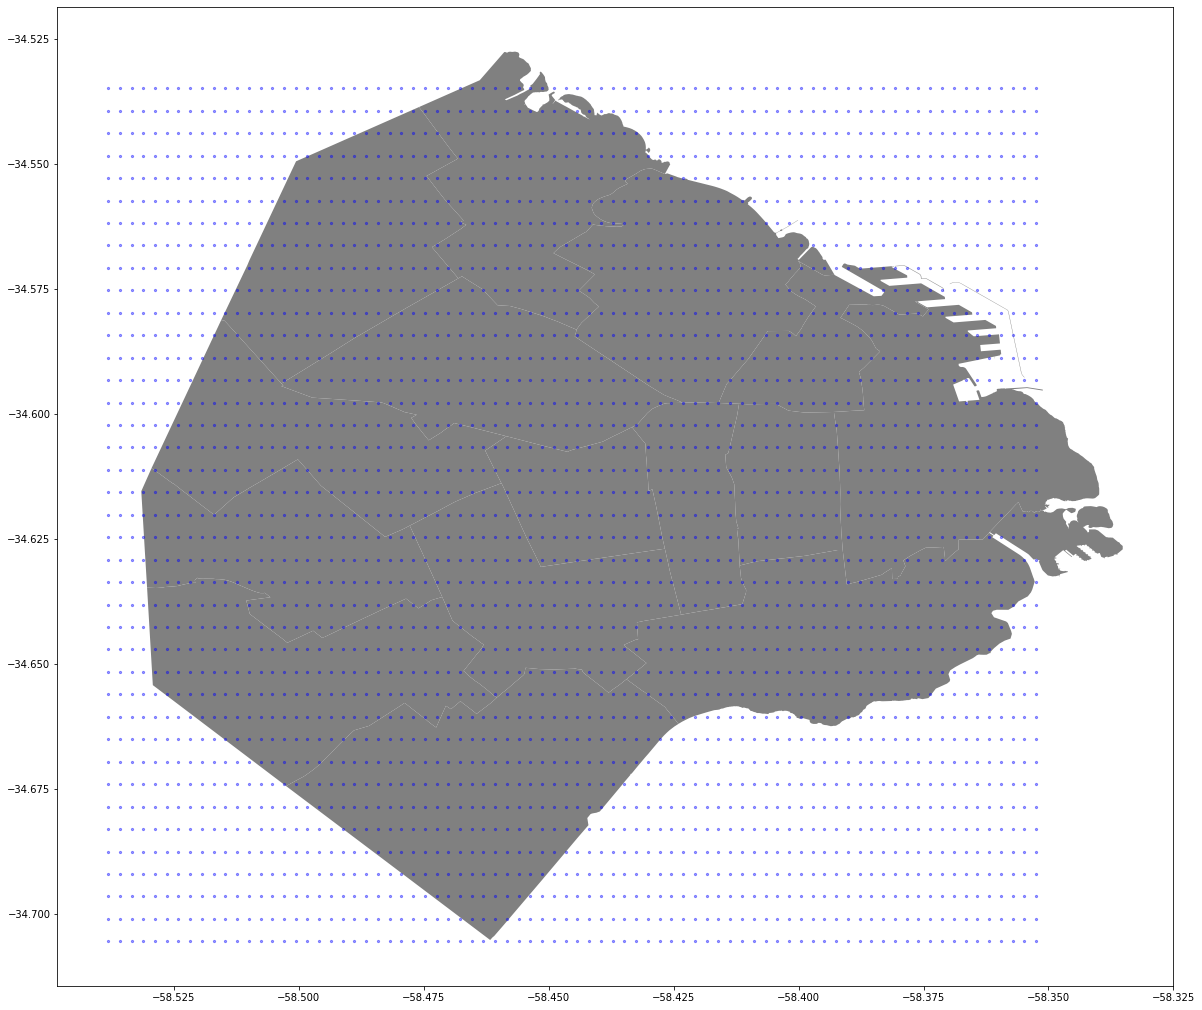

In [15]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='grey')
gdf.plot(ax=ax, markersize=5, alpha=0.4, color='blue')

In [16]:
import numpy as np


la grilla tiene 42x47

In [17]:
grid = np.zeros((41,46))

In [18]:
data = pd.read_json('backupPretty.json')
data

,000WNcNhS9wfCdf7iEOX,008zo6J8K0pPZJgKclLI,00JkrTgN0KjJ1J5Yh0BC,00L6IRxzMVYbrgzTtmMZ,00NrI3r0ispoBQiCky52,02JQQDvLvkQKD7zArcIt,03aL2ApNN4rxcQ2oj0C5,048yly1xDWYCxMMe5zbF,04O66oLhVZDapYLX6Af2,05Ec7CgFPoMx4toq0PxD,...,zxeQ6i0VIXLUcyd7Pdvc,zxlHjgpcsG58gheE3lnE,zxok8FTQwO3txHmIFvYg,zy03nsfNNe1eiuDbe8Lb,zyeVkG9RBXmG9CD5JDbd,zyltmkCke5gMNVHYPh3Y,zz1gRTQiFOCjumNDczpt,zzIJguUu3JxatxpAfOES,zzKiAzWUPC5LUIB6iOrV,zzcQRoM3KAwzS9W37MOg
search_longitude,-58.419543,-58.414274,-58.433503,-58.440447,-58.418288,-58.565081,-58.208933,-58.916742,-58.643991,-58.603364,...,-58.458972,-58.385121,-58.536259,-58.539242,-122.406417,-58.512720,-58.507150,-58.383415,-58.413258,-58.511532
leave,2021-02-04T20:00:36.491GMT-03:00,2021-01-12T14:30:04.743GMT-03:00,2021-02-05T12:30:35.344GMT-03:00,2021-02-28T14:32:00.000-03:00,2021-02-13T13:12:45.668-03:00,2021-01-06T17:15:55.565GMT-03:00,2021-01-25T15:45:27.320-03:00,2021-01-26T19:15:49.732GMT-03:00,2021-02-02T10:45:04.786GMT-03:00,2021-01-09T19:30:12.632GMT-03:00,...,2021-02-08T03:33:27.798-03:00,2021-02-06T15:45:46.006-03:00,2020-12-21T17:00:00.000GMT-03:00,2021-02-16T23:49:07.945-03:00,2021-01-10T21:00:01.289GMT-03:00,2020-11-17T12:15:00.000GMT-03:00,2020-09-14T10:45:26.622GMT-03:00,2021-01-23T08:15:18.431GMT-03:00,2021-01-06T6:15:01.800GMT-03:00,2021-01-25T12:28:25.262-03:00
search_method,startup,startup,startup,google,searchInThisArea,startup,searchInThisArea,startup,startup,startup,...,searchInThisArea,searchInThisArea,update_time_home,google,startup,google,startup,this_area,startup,searchInThisArea
uid,unauthenticated,unauthenticated,unauthenticated,None,e8itgepSU1YX6Q48HtrDpz76OXr1,VQmERwQmoAah7aFr3oyhPw3osrj1,None,unauthenticated,eoKzUjMqxQVmXkcbzMF5edWexGs1,CKMmhmI2ZOdD7kZHudefzuAOxLY2,...,W2UoC9eld8MNS08rn8W2KVqKCYB2,None,unauthenticated,None,CKMmhmI2ZOdD7kZHudefzuAOxLY2,BLLbW2aUT4Xd5Kyu4lUX98MMget1,unauthenticated,unauthenticated,unauthenticated,None
user_longitude,1,1,1,None,-58.477347,1,None,1,1,1,...,-58.463061,None,1,None,1,1,1,1,1,-58.511532
timestamp,2021-02-04T18:56:36.493GMT-03:00,2021-01-12T13:28:04.752GMT-03:00,2021-02-05T11:19:35.351GMT-03:00,2021-01-31T19:35:42.438-03:00,2021-02-13T12:13:03.714-03:00,2021-01-06T16:11:55.570GMT-03:00,2021-01-25T14:45:44.753-03:00,2021-01-26T18:01:49.768GMT-03:00,2021-02-02T09:32:04.790GMT-03:00,2021-01-09T18:17:12.638GMT-03:00,...,2021-02-08T02:36:12.024-03:00,2021-02-06T14:46:26.843-03:00,2020-12-21T10:57:42.699GMT-03:00,2021-02-16T22:49:24.602-03:00,2021-01-10T19:55:01.293GMT-03:00,2020-11-17T09:32:01.879GMT-03:00,2020-09-14T09:35:26.624GMT-03:00,2021-01-23T07:12:43.879GMT-03:00,2021-01-06T5:05:01.826GMT-03:00,2021-01-25T11:28:28.244-03:00
arrive,2021-02-04T19:00:36.491GMT-03:00,2021-01-12T13:30:04.743GMT-03:00,2021-02-05T11:30:35.344GMT-03:00,2021-02-28T12:56:00.000-03:00,2021-02-13T12:12:45.668-03:00,2021-01-06T16:15:55.565GMT-03:00,2021-01-25T14:45:27.320-03:00,2021-01-26T18:15:49.732GMT-03:00,2021-02-02T09:45:04.786GMT-03:00,2021-01-09T18:30:12.632GMT-03:00,...,2021-02-08T02:33:27.798-03:00,2021-02-06T14:45:46.006-03:00,2020-12-21T11:00:54.782GMT-03:00,2021-02-16T22:49:07.945-03:00,2021-01-10T20:00:01.289GMT-03:00,2020-11-17T12:00:00.000GMT-03:00,2020-09-14T09:45:26.622GMT-03:00,2021-01-23T07:15:18.431GMT-03:00,2021-01-06T5:15:01.800GMT-03:00,2021-01-25T11:28:25.262-03:00
user_latitude,1,1,1,None,-34.508772,1,None,1,1,1,...,-34.618984,None,1,None,1,1,1,1,1,-34.471758
search_latitude,-34.575729,-34.581036,-34.577048,-34.620694,-34.581668,-34.829835,-34.831096,-34.513153,-34.390456,-34.464591,...,-34.618296,-34.620749,-34.624580,-34.812266,37.785834,-34.469415,-34.575842,-34.591915,-34.584307,-34.471748
__collections__,{},{},{},{},{},{},{},{},{},{},...,{},{},{},{},{},{},{},{},{},{}


In [19]:
data = data.T
data.head()

,search_longitude,leave,search_method,uid,user_longitude,timestamp,arrive,user_latitude,search_latitude,__collections__
000WNcNhS9wfCdf7iEOX,-58.419543,2021-02-04T20:00:36.491GMT-03:00,startup,unauthenticated,1,2021-02-04T18:56:36.493GMT-03:00,2021-02-04T19:00:36.491GMT-03:00,1,-34.575729,{}
008zo6J8K0pPZJgKclLI,-58.414274,2021-01-12T14:30:04.743GMT-03:00,startup,unauthenticated,1,2021-01-12T13:28:04.752GMT-03:00,2021-01-12T13:30:04.743GMT-03:00,1,-34.581036,{}
00JkrTgN0KjJ1J5Yh0BC,-58.433503,2021-02-05T12:30:35.344GMT-03:00,startup,unauthenticated,1,2021-02-05T11:19:35.351GMT-03:00,2021-02-05T11:30:35.344GMT-03:00,1,-34.577048,{}
00L6IRxzMVYbrgzTtmMZ,-58.440447,2021-02-28T14:32:00.000-03:00,google,None,None,2021-01-31T19:35:42.438-03:00,2021-02-28T12:56:00.000-03:00,None,-34.620694,{}
00NrI3r0ispoBQiCky52,-58.418288,2021-02-13T13:12:45.668-03:00,searchInThisArea,e8itgepSU1YX6Q48HtrDpz76OXr1,-58.477347,2021-02-13T12:13:03.714-03:00,2021-02-13T12:12:45.668-03:00,-34.508772,-34.581668,{}


In [20]:
data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])

In [21]:
data = data[['search_longitude', 'search_latitude', 'arrive', 'leave','search_method', 'timestamp', 'uid']]

In [22]:
data.reset_index(level=0, inplace=True) 

In [23]:
data.rename(columns={"index": "search_track"})

,search_track,search_longitude,search_latitude,arrive,leave,search_method,timestamp,uid
0,000WNcNhS9wfCdf7iEOX,-58.419543,-34.575729,2021-02-04T19:00:36.491GMT-03:00,2021-02-04T20:00:36.491GMT-03:00,startup,2021-02-04T18:56:36.493GMT-03:00,unauthenticated
1,008zo6J8K0pPZJgKclLI,-58.414274,-34.581036,2021-01-12T13:30:04.743GMT-03:00,2021-01-12T14:30:04.743GMT-03:00,startup,2021-01-12T13:28:04.752GMT-03:00,unauthenticated
2,00JkrTgN0KjJ1J5Yh0BC,-58.433503,-34.577048,2021-02-05T11:30:35.344GMT-03:00,2021-02-05T12:30:35.344GMT-03:00,startup,2021-02-05T11:19:35.351GMT-03:00,unauthenticated
3,00L6IRxzMVYbrgzTtmMZ,-58.440447,-34.620694,2021-02-28T12:56:00.000-03:00,2021-02-28T14:32:00.000-03:00,google,2021-01-31T19:35:42.438-03:00,None
4,00NrI3r0ispoBQiCky52,-58.418288,-34.581668,2021-02-13T12:12:45.668-03:00,2021-02-13T13:12:45.668-03:00,searchInThisArea,2021-02-13T12:13:03.714-03:00,e8itgepSU1YX6Q48HtrDpz76OXr1
...,...,...,...,...,...,...,...,...
11776,zyltmkCke5gMNVHYPh3Y,-58.512720,-34.469415,2020-11-17T12:00:00.000GMT-03:00,2020-11-17T12:15:00.000GMT-03:00,google,2020-11-17T09:32:01.879GMT-03:00,BLLbW2aUT4Xd5Kyu4lUX98MMget1
11777,zz1gRTQiFOCjumNDczpt,-58.507150,-34.575842,2020-09-14T09:45:26.622GMT-03:00,2020-09-14T10:45:26.622GMT-03:00,startup,2020-09-14T09:35:26.624GMT-03:00,unauthenticated
11778,zzIJguUu3JxatxpAfOES,-58.383415,-34.591915,2021-01-23T07:15:18.431GMT-03:00,2021-01-23T08:15:18.431GMT-03:00,this_area,2021-01-23T07:12:43.879GMT-03:00,unauthenticated
11779,zzKiAzWUPC5LUIB6iOrV,-58.413258,-34.584307,2021-01-06T5:15:01.800GMT-03:00,2021-01-06T6:15:01.800GMT-03:00,startup,2021-01-06T5:05:01.826GMT-03:00,unauthenticated


In [24]:
data['search_method'] = data['search_method'].convert_dtypes()

In [25]:
data['search_method'].dtypes

StringDtype

In [26]:
data["search_method"]

0                 startup
1                 startup
2                 startup
3                  google
4        searchInThisArea
               ...       
11776              google
11777             startup
11778           this_area
11779             startup
11780    searchInThisArea
Name: search_method, Length: 11781, dtype: string

In [27]:
data = data[data.search_method != 'startup']
data.head()

,index,search_longitude,search_latitude,arrive,leave,search_method,timestamp,uid
3,00L6IRxzMVYbrgzTtmMZ,-58.440447,-34.620694,2021-02-28T12:56:00.000-03:00,2021-02-28T14:32:00.000-03:00,google,2021-01-31T19:35:42.438-03:00,None
4,00NrI3r0ispoBQiCky52,-58.418288,-34.581668,2021-02-13T12:12:45.668-03:00,2021-02-13T13:12:45.668-03:00,searchInThisArea,2021-02-13T12:13:03.714-03:00,e8itgepSU1YX6Q48HtrDpz76OXr1
6,03aL2ApNN4rxcQ2oj0C5,-58.208933,-34.831096,2021-01-25T14:45:27.320-03:00,2021-01-25T15:45:27.320-03:00,searchInThisArea,2021-01-25T14:45:44.753-03:00,None
10,05QvDNh2VEMjSmEf7c0g,-58.454943,-34.564354,2021-02-25T08:20:09.755-03:00,2021-02-25T09:20:09.755-03:00,searchInThisArea,2021-02-25T08:22:32.254-03:00,None
11,05kFhaZNwSozsmX5xA8h,-58.451924,-34.559296,2020-09-17T13:45:00.000GMT-03:00,2020-09-17T14:00:00.000GMT-03:00,update_time_home,2020-09-17T08:13:03.302GMT-03:00,unauthenticated


In [28]:
gpd_data = gpd.GeoDataFrame(data,
                         crs = epsg, 
                         geometry = gpd.points_from_xy(data.search_longitude, data.search_latitude))
gpd_data.head(50)

,index,search_longitude,search_latitude,arrive,leave,search_method,timestamp,uid,geometry
3,00L6IRxzMVYbrgzTtmMZ,-58.440447,-34.620694,2021-02-28T12:56:00.000-03:00,2021-02-28T14:32:00.000-03:00,google,2021-01-31T19:35:42.438-03:00,None,POINT (-58.44045 -34.62069)
4,00NrI3r0ispoBQiCky52,-58.418288,-34.581668,2021-02-13T12:12:45.668-03:00,2021-02-13T13:12:45.668-03:00,searchInThisArea,2021-02-13T12:13:03.714-03:00,e8itgepSU1YX6Q48HtrDpz76OXr1,POINT (-58.41829 -34.58167)
6,03aL2ApNN4rxcQ2oj0C5,-58.208933,-34.831096,2021-01-25T14:45:27.320-03:00,2021-01-25T15:45:27.320-03:00,searchInThisArea,2021-01-25T14:45:44.753-03:00,None,POINT (-58.20893 -34.83110)
10,05QvDNh2VEMjSmEf7c0g,-58.454943,-34.564354,2021-02-25T08:20:09.755-03:00,2021-02-25T09:20:09.755-03:00,searchInThisArea,2021-02-25T08:22:32.254-03:00,None,POINT (-58.45494 -34.56435)
11,05kFhaZNwSozsmX5xA8h,-58.451924,-34.559296,2020-09-17T13:45:00.000GMT-03:00,2020-09-17T14:00:00.000GMT-03:00,update_time_home,2020-09-17T08:13:03.302GMT-03:00,unauthenticated,POINT (-58.45192 -34.55930)
12,05mp6lWKUHNociTcQQ6m,-58.463061,-34.618974,2021-02-08T02:38:42.027-03:00,2021-02-08T03:38:42.027-03:00,searchInThisArea,2021-02-08T02:38:45.031-03:00,W2UoC9eld8MNS08rn8W2KVqKCYB2,POINT (-58.46306 -34.61897)
14,06H5EhRG878sEhZkfM1E,-58.428174,-34.581082,2021-01-02T17:00:55.767GMT-03:00,2021-01-02T18:00:55.767GMT-03:00,this_area,2021-01-02T17:00:04.965GMT-03:00,unauthenticated,POINT (-58.42817 -34.58108)
16,06mLgJ8yPnURcSpYOhSA,-58.463378,-34.618813,2021-02-18T23:38:56.659-03:00,2021-02-19T00:38:56.659-03:00,searchInThisArea,2021-02-18T23:38:59.051-03:00,W2UoC9eld8MNS08rn8W2KVqKCYB2,POINT (-58.46338 -34.61881)
17,06tbJwFTBo1dh8i8s7ZJ,-58.425649,-34.584155,2021-02-10T14:15:32.953GMT-03:00,2021-02-10T15:15:32.953GMT-03:00,this_area,2021-02-10T14:10:42.798GMT-03:00,7UpA10J8BpPuSH4uA2khCcEosXo1,POINT (-58.42565 -34.58415)
18,06wSv36fSA1U3QO9ZVAH,-58.437593,-34.572329,2020-10-24T17:45:38.459GMT-03:00,2020-10-24T18:45:38.459GMT-03:00,this_area,2020-10-24T17:52:21.598GMT-03:00,unauthenticated,POINT (-58.43759 -34.57233)


(-34.7, -34.525)

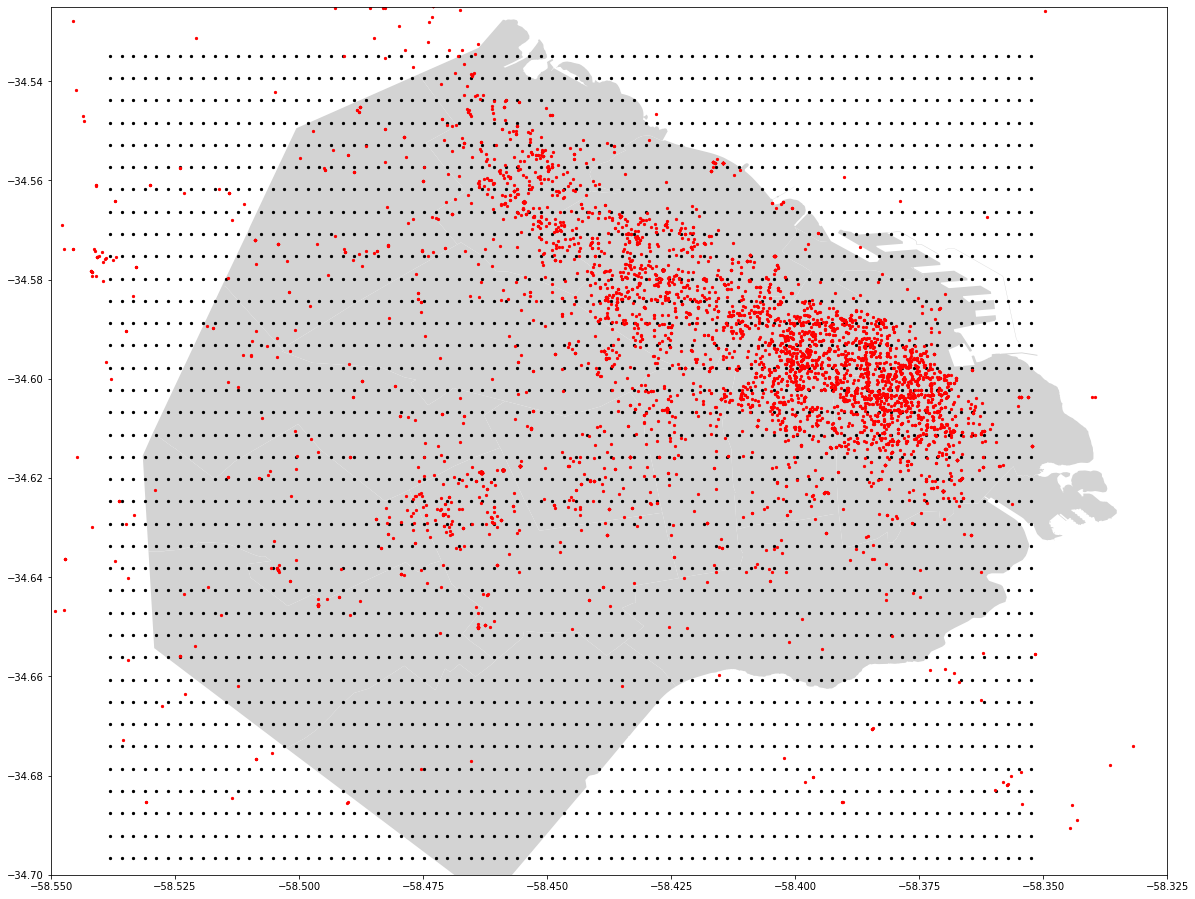

In [135]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=5, color='black')
gpd_data.plot(ax=ax, markersize=5, color='red')
ax.set_xlim([-58.550, -58.325])
ax.set_ylim([-34.700, -34.525])


In [98]:
grid_coordinates_gdf = gdf.copy()

In [99]:
grid_coordinates_gdf['x'] = grid_coordinates_gdf['lat']
grid_coordinates_gdf['y'] = grid_coordinates_gdf['lon']
grid_coordinates_gdf.drop(columns = ['lat', 'lon'], inplace=True)

In [100]:
grid_coordinates_gdf

,geometry,x,y
0,POINT (-58.53814 -34.70556),-58.538143,-34.705557
1,POINT (-58.53580 -34.70556),-58.535799,-34.705557
2,POINT (-58.53345 -34.70556),-58.533454,-34.705557
3,POINT (-58.53111 -34.70556),-58.531109,-34.705557
4,POINT (-58.52876 -34.70556),-58.528765,-34.705557
...,...,...,...
3115,POINT (-58.36188 -34.53488),-58.361880,-34.534877
3116,POINT (-58.35952 -34.53488),-58.359524,-34.534877
3117,POINT (-58.35717 -34.53488),-58.357167,-34.534877
3118,POINT (-58.35481 -34.53488),-58.354811,-34.534877


In [101]:
def coord_to_numsx(x):
    initial_x = 58.538143
    new_x = initial_x + x
    return new_x
    

def coord_to_numsy(y): 
    initial_y = 34.705557
    new_y = initial_y + y
    return new_y
    


In [102]:
grid_coordinates_gdf["new_x"] = grid_coordinates_gdf["x"].map(coord_to_numsx)
grid_coordinates_gdf["new_y"] = grid_coordinates_gdf["y"].map(coord_to_numsy)


In [103]:
grid_coordinates_gdf.drop(columns = ['geometry', 'x', 'y'], inplace=True)

In [104]:
grid_coordinates_gdf = pd.DataFrame(grid_coordinates_gdf)

grid_coordinates_gdf

,new_x,new_y
0,0.000000,0.00000
1,0.002344,0.00000
2,0.004689,0.00000
3,0.007034,0.00000
4,0.009378,0.00000
...,...,...
3115,0.176263,0.17068
3116,0.178619,0.17068
3117,0.180976,0.17068
3118,0.183332,0.17068


In [113]:
# fig,ax = plt.subplots(figsize = (20,20))
# grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
# # ax.set_xlim([0, 0.2])
# # ax.set_ylim([0,0.2])

In [126]:
grid_coordinates_data = gpd_data.copy()
grid_coordinates_data

,index,search_longitude,search_latitude,arrive,leave,search_method,timestamp,uid,geometry
3,00L6IRxzMVYbrgzTtmMZ,-58.440447,-34.620694,2021-02-28T12:56:00.000-03:00,2021-02-28T14:32:00.000-03:00,google,2021-01-31T19:35:42.438-03:00,None,POINT (-58.44045 -34.62069)
4,00NrI3r0ispoBQiCky52,-58.418288,-34.581668,2021-02-13T12:12:45.668-03:00,2021-02-13T13:12:45.668-03:00,searchInThisArea,2021-02-13T12:13:03.714-03:00,e8itgepSU1YX6Q48HtrDpz76OXr1,POINT (-58.41829 -34.58167)
6,03aL2ApNN4rxcQ2oj0C5,-58.208933,-34.831096,2021-01-25T14:45:27.320-03:00,2021-01-25T15:45:27.320-03:00,searchInThisArea,2021-01-25T14:45:44.753-03:00,None,POINT (-58.20893 -34.83110)
10,05QvDNh2VEMjSmEf7c0g,-58.454943,-34.564354,2021-02-25T08:20:09.755-03:00,2021-02-25T09:20:09.755-03:00,searchInThisArea,2021-02-25T08:22:32.254-03:00,None,POINT (-58.45494 -34.56435)
11,05kFhaZNwSozsmX5xA8h,-58.451924,-34.559296,2020-09-17T13:45:00.000GMT-03:00,2020-09-17T14:00:00.000GMT-03:00,update_time_home,2020-09-17T08:13:03.302GMT-03:00,unauthenticated,POINT (-58.45192 -34.55930)
...,...,...,...,...,...,...,...,...,...
11773,zxok8FTQwO3txHmIFvYg,-58.536259,-34.624580,2020-12-21T11:00:54.782GMT-03:00,2020-12-21T17:00:00.000GMT-03:00,update_time_home,2020-12-21T10:57:42.699GMT-03:00,unauthenticated,POINT (-58.53626 -34.62458)
11774,zy03nsfNNe1eiuDbe8Lb,-58.539242,-34.812266,2021-02-16T22:49:07.945-03:00,2021-02-16T23:49:07.945-03:00,google,2021-02-16T22:49:24.602-03:00,None,POINT (-58.53924 -34.81227)
11776,zyltmkCke5gMNVHYPh3Y,-58.512720,-34.469415,2020-11-17T12:00:00.000GMT-03:00,2020-11-17T12:15:00.000GMT-03:00,google,2020-11-17T09:32:01.879GMT-03:00,BLLbW2aUT4Xd5Kyu4lUX98MMget1,POINT (-58.51272 -34.46942)
11778,zzIJguUu3JxatxpAfOES,-58.383415,-34.591915,2021-01-23T07:15:18.431GMT-03:00,2021-01-23T08:15:18.431GMT-03:00,this_area,2021-01-23T07:12:43.879GMT-03:00,unauthenticated,POINT (-58.38341 -34.59192)


In [127]:
grid_coordinates_data['x'] = grid_coordinates_data['search_longitude']
grid_coordinates_data['y'] = grid_coordinates_data['search_latitude']
grid_coordinates_data.drop(columns = ['search_latitude', 'search_longitude'], inplace=True)
grid_coordinates_data

,index,arrive,leave,search_method,timestamp,uid,geometry,x,y
3,00L6IRxzMVYbrgzTtmMZ,2021-02-28T12:56:00.000-03:00,2021-02-28T14:32:00.000-03:00,google,2021-01-31T19:35:42.438-03:00,None,POINT (-58.44045 -34.62069),-58.440447,-34.620694
4,00NrI3r0ispoBQiCky52,2021-02-13T12:12:45.668-03:00,2021-02-13T13:12:45.668-03:00,searchInThisArea,2021-02-13T12:13:03.714-03:00,e8itgepSU1YX6Q48HtrDpz76OXr1,POINT (-58.41829 -34.58167),-58.418288,-34.581668
6,03aL2ApNN4rxcQ2oj0C5,2021-01-25T14:45:27.320-03:00,2021-01-25T15:45:27.320-03:00,searchInThisArea,2021-01-25T14:45:44.753-03:00,None,POINT (-58.20893 -34.83110),-58.208933,-34.831096
10,05QvDNh2VEMjSmEf7c0g,2021-02-25T08:20:09.755-03:00,2021-02-25T09:20:09.755-03:00,searchInThisArea,2021-02-25T08:22:32.254-03:00,None,POINT (-58.45494 -34.56435),-58.454943,-34.564354
11,05kFhaZNwSozsmX5xA8h,2020-09-17T13:45:00.000GMT-03:00,2020-09-17T14:00:00.000GMT-03:00,update_time_home,2020-09-17T08:13:03.302GMT-03:00,unauthenticated,POINT (-58.45192 -34.55930),-58.451924,-34.559296
...,...,...,...,...,...,...,...,...,...
11773,zxok8FTQwO3txHmIFvYg,2020-12-21T11:00:54.782GMT-03:00,2020-12-21T17:00:00.000GMT-03:00,update_time_home,2020-12-21T10:57:42.699GMT-03:00,unauthenticated,POINT (-58.53626 -34.62458),-58.536259,-34.624580
11774,zy03nsfNNe1eiuDbe8Lb,2021-02-16T22:49:07.945-03:00,2021-02-16T23:49:07.945-03:00,google,2021-02-16T22:49:24.602-03:00,None,POINT (-58.53924 -34.81227),-58.539242,-34.812266
11776,zyltmkCke5gMNVHYPh3Y,2020-11-17T12:00:00.000GMT-03:00,2020-11-17T12:15:00.000GMT-03:00,google,2020-11-17T09:32:01.879GMT-03:00,BLLbW2aUT4Xd5Kyu4lUX98MMget1,POINT (-58.51272 -34.46942),-58.512720,-34.469415
11778,zzIJguUu3JxatxpAfOES,2021-01-23T07:15:18.431GMT-03:00,2021-01-23T08:15:18.431GMT-03:00,this_area,2021-01-23T07:12:43.879GMT-03:00,unauthenticated,POINT (-58.38341 -34.59192),-58.383415,-34.591915


In [128]:
grid_coordinates_data["new_x"] = grid_coordinates_data["x"].map(coord_to_numsx)
grid_coordinates_data["new_y"] = grid_coordinates_data["y"].map(coord_to_numsy)
grid_coordinates_data = pd.DataFrame(grid_coordinates_data)

grid_coordinates_data

,index,arrive,leave,search_method,timestamp,uid,geometry,x,y,new_x,new_y
3,00L6IRxzMVYbrgzTtmMZ,2021-02-28T12:56:00.000-03:00,2021-02-28T14:32:00.000-03:00,google,2021-01-31T19:35:42.438-03:00,None,POINT (-58.44045 -34.62069),-58.440447,-34.620694,0.097696,0.084863
4,00NrI3r0ispoBQiCky52,2021-02-13T12:12:45.668-03:00,2021-02-13T13:12:45.668-03:00,searchInThisArea,2021-02-13T12:13:03.714-03:00,e8itgepSU1YX6Q48HtrDpz76OXr1,POINT (-58.41829 -34.58167),-58.418288,-34.581668,0.119855,0.123889
6,03aL2ApNN4rxcQ2oj0C5,2021-01-25T14:45:27.320-03:00,2021-01-25T15:45:27.320-03:00,searchInThisArea,2021-01-25T14:45:44.753-03:00,None,POINT (-58.20893 -34.83110),-58.208933,-34.831096,0.329210,-0.125539
10,05QvDNh2VEMjSmEf7c0g,2021-02-25T08:20:09.755-03:00,2021-02-25T09:20:09.755-03:00,searchInThisArea,2021-02-25T08:22:32.254-03:00,None,POINT (-58.45494 -34.56435),-58.454943,-34.564354,0.083200,0.141203
11,05kFhaZNwSozsmX5xA8h,2020-09-17T13:45:00.000GMT-03:00,2020-09-17T14:00:00.000GMT-03:00,update_time_home,2020-09-17T08:13:03.302GMT-03:00,unauthenticated,POINT (-58.45192 -34.55930),-58.451924,-34.559296,0.086219,0.146261
...,...,...,...,...,...,...,...,...,...,...,...
11773,zxok8FTQwO3txHmIFvYg,2020-12-21T11:00:54.782GMT-03:00,2020-12-21T17:00:00.000GMT-03:00,update_time_home,2020-12-21T10:57:42.699GMT-03:00,unauthenticated,POINT (-58.53626 -34.62458),-58.536259,-34.624580,0.001884,0.080977
11774,zy03nsfNNe1eiuDbe8Lb,2021-02-16T22:49:07.945-03:00,2021-02-16T23:49:07.945-03:00,google,2021-02-16T22:49:24.602-03:00,None,POINT (-58.53924 -34.81227),-58.539242,-34.812266,-0.001099,-0.106709
11776,zyltmkCke5gMNVHYPh3Y,2020-11-17T12:00:00.000GMT-03:00,2020-11-17T12:15:00.000GMT-03:00,google,2020-11-17T09:32:01.879GMT-03:00,BLLbW2aUT4Xd5Kyu4lUX98MMget1,POINT (-58.51272 -34.46942),-58.512720,-34.469415,0.025423,0.236142
11778,zzIJguUu3JxatxpAfOES,2021-01-23T07:15:18.431GMT-03:00,2021-01-23T08:15:18.431GMT-03:00,this_area,2021-01-23T07:12:43.879GMT-03:00,unauthenticated,POINT (-58.38341 -34.59192),-58.383415,-34.591915,0.154728,0.113642


(0.0, 0.2)

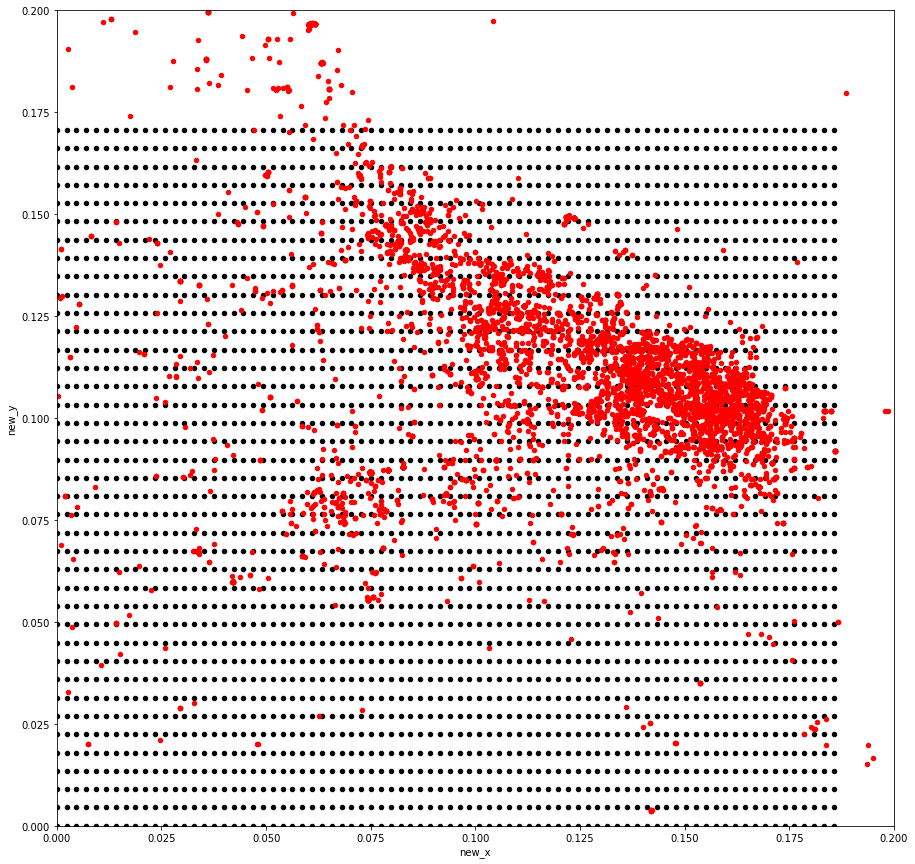

In [164]:
fig,ax = plt.subplots(figsize = (15,15))
grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
grid_coordinates_data.plot(ax=ax, color='red', x='new_x', y='new_y', kind='scatter')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,0.2])

In [147]:
grid_coordinates_gdf.head(90)

,new_x,new_y
0,0.000000,0.000000
1,0.002344,0.000000
2,0.004689,0.000000
3,0.007034,0.000000
4,0.009378,0.000000
...,...,...
85,0.011723,0.004492
86,0.014069,0.004492
87,0.016414,0.004492
88,0.018759,0.004492


In [165]:
grid_coordinates_gdf.new_x.nunique()

80

In [148]:

def data_in_gdf(x,y):
    
    x_column = x/0.002345
    y_column = y/0.004492
    
    return int(x_column), int(y_column)
    

In [160]:
print(grid_coordinates_data.loc[[11778]])

                      index                            arrive  \
11778  zzIJguUu3JxatxpAfOES  2021-01-23T07:15:18.431GMT-03:00   

                                  leave search_method  \
11778  2021-01-23T08:15:18.431GMT-03:00     this_area   

                              timestamp              uid  \
11778  2021-01-23T07:12:43.879GMT-03:00  unauthenticated   

                          geometry          x          y     new_x     new_y  
11778  POINT (-58.38341 -34.59192) -58.383415 -34.591915  0.154728  0.113642  


In [161]:
data_in_gdf(0.154728,0.113642)

(65, 25)